# Predictive Analysis of Annual Enterprise Survey

In [ ]:
# Importing All Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import types as T
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.ml.feature import *
import warnings
warnings.filterwarnings("ignore")
import pyspark
import findspark
findspark.init()
findspark.find()

'C:\\Users\\Dell\\AppData\\Roaming\\Python\\Python38\\site-packages\\pyspark'

In [2]:
# Import spark libraries
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkContext
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.functions import isnull,when,count
from pyspark.ml.feature import StringIndexer

In [3]:
#Machine Learning Data+Monngodb Connection
inp="mongodb://127.0.0.1/Project.CleanData"
outp="mongodb://127.0.0.1/Project.CleanData"
mongodb_spark_jars_path="D:\\DBDA_Project\\Cambrium-bio-solution-main\\mongojars\\"

In [4]:
#Vizulization Data connection
inp="mongodb://127.0.0.1/Project.ActualData"
outp="mongodb://127.0.0.1/Project.ActualData"

In [5]:
spark=SparkSession.builder.appName("ProjectData")\
    .config("spark.mongodb.input.uri",inp)\
    .config("spark.mongodb.output.uri",outp)\
    .config("spark.jars",""+mongodb_spark_jars_path+"mongo-spark-connector_2.12-3.0.1.jar,"+mongodb_spark_jars_path+"bson-4.0.5.jar,"+mongodb_spark_jars_path+"mongodb-driver-core-4.0.5.jar,"+mongodb_spark_jars_path+"mongodb-driver-sync-4.0.5.jar")\
    .getOrCreate()

# Raw Data Collection

In [6]:
url = "https://www.stats.govt.nz/assets/Uploads/Annual-enterprise-survey/Annual-enterprise-survey-2020-financial-year-provisional/Download-data/annual-enterprise-survey-2020-financial-year-provisional-csv.csv"
from pyspark import SparkFiles
spark.sparkContext.addFile(url)
df = spark.read.option("header","true").option("inferSchema","true").csv(SparkFiles.get("annual-enterprise-survey-2020-financial-year-provisional-csv.csv"))
df.show()


+----+---------------------------+--------------------+--------------------+------------------+-------------+--------------------+--------------------+---------+----------------------+
|Year|Industry_aggregation_NZSIOC|Industry_code_NZSIOC|Industry_name_NZSIOC|             Units|Variable_code|       Variable_name|   Variable_category|    Value|Industry_code_ANZSIC06|
+----+---------------------------+--------------------+--------------------+------------------+-------------+--------------------+--------------------+---------+----------------------+
|2020|                    Level 1|               99999|      All industries|Dollars (millions)|          H01|        Total income|Financial perform...|  733,258|  ANZSIC06 division...|
|2020|                    Level 1|               99999|      All industries|Dollars (millions)|          H04|Sales, government...|Financial perform...|  660,630|  ANZSIC06 division...|
|2020|                    Level 1|               99999|      All industries

In [7]:
df.printSchema()
df.columns

root
 |-- Year: integer (nullable = true)
 |-- Industry_aggregation_NZSIOC: string (nullable = true)
 |-- Industry_code_NZSIOC: string (nullable = true)
 |-- Industry_name_NZSIOC: string (nullable = true)
 |-- Units: string (nullable = true)
 |-- Variable_code: string (nullable = true)
 |-- Variable_name: string (nullable = true)
 |-- Variable_category: string (nullable = true)
 |-- Value: string (nullable = true)
 |-- Industry_code_ANZSIC06: string (nullable = true)



['Year',
 'Industry_aggregation_NZSIOC',
 'Industry_code_NZSIOC',
 'Industry_name_NZSIOC',
 'Units',
 'Variable_code',
 'Variable_name',
 'Variable_category',
 'Value',
 'Industry_code_ANZSIC06']

# Data typecasting

In [8]:
# To convert the columns into float data type (Strint to float)

df = df.withColumn('Value', regexp_replace('Value', ',',''))

In [9]:
from pyspark.sql.types import *
df=df.withColumn("Value",df.Value.cast(DoubleType()))

In [10]:
df.printSchema()

df.show()

root
 |-- Year: integer (nullable = true)
 |-- Industry_aggregation_NZSIOC: string (nullable = true)
 |-- Industry_code_NZSIOC: string (nullable = true)
 |-- Industry_name_NZSIOC: string (nullable = true)
 |-- Units: string (nullable = true)
 |-- Variable_code: string (nullable = true)
 |-- Variable_name: string (nullable = true)
 |-- Variable_category: string (nullable = true)
 |-- Value: double (nullable = true)
 |-- Industry_code_ANZSIC06: string (nullable = true)

+----+---------------------------+--------------------+--------------------+------------------+-------------+--------------------+--------------------+---------+----------------------+
|Year|Industry_aggregation_NZSIOC|Industry_code_NZSIOC|Industry_name_NZSIOC|             Units|Variable_code|       Variable_name|   Variable_category|    Value|Industry_code_ANZSIC06|
+----+---------------------------+--------------------+--------------------+------------------+-------------+--------------------+--------------------+------

# Data Cleaning 

In [11]:
# Data Cleaning and Feature Engineering

import pyspark.sql.functions as func
for col in df.columns:
    df = df.withColumn(col, func.ltrim(func.rtrim(df[col])))

In [12]:
df=df.drop('Units')

df=df.drop('Industry_code_ANZSIC06')

In [13]:
df.show()

+----+---------------------------+--------------------+--------------------+-------------+--------------------+--------------------+---------+
|Year|Industry_aggregation_NZSIOC|Industry_code_NZSIOC|Industry_name_NZSIOC|Variable_code|       Variable_name|   Variable_category|    Value|
+----+---------------------------+--------------------+--------------------+-------------+--------------------+--------------------+---------+
|2020|                    Level 1|               99999|      All industries|          H01|        Total income|Financial perform...| 733258.0|
|2020|                    Level 1|               99999|      All industries|          H04|Sales, government...|Financial perform...| 660630.0|
|2020|                    Level 1|               99999|      All industries|          H05|Interest, dividen...|Financial perform...|  54342.0|
|2020|                    Level 1|               99999|      All industries|          H07|Non-operating income|Financial perform...|  18285.0|

# Data for Data Visualization load to MongoDB

In [14]:
#Loading Libraries
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark import SparkConf

In [15]:
df.write.format("com.mongodb.spark.sql.DefaultSource")\
    .mode("overwrite")\
    .option("database","Project")\
    .option("collection", "ActualData")\
    .save()

In [16]:
# Adding some features to existing dataframe 

indexer=StringIndexer(inputCol='Year',outputCol='YearI')
index_df=indexer.fit(df).transform(df)
indexer=StringIndexer(inputCol='Industry_aggregation_NZSIOC',outputCol='Industry_aggregation_NZSIOCI')
index_df=indexer.fit(index_df).transform(index_df)
indexer=StringIndexer(inputCol='Industry_code_NZSIOC',outputCol='Industry_code_NZSIOCI')
index_df=indexer.fit(index_df).transform(index_df)
indexer=StringIndexer(inputCol='Industry_name_NZSIOC',outputCol='Industry_name_NZSIOCI')
index_df=indexer.fit(index_df).transform(index_df)
indexer=StringIndexer(inputCol='Variable_code',outputCol='Variable_codeI')
index_df=indexer.fit(index_df).transform(index_df)
indexer=StringIndexer(inputCol='Variable_name',outputCol='Variable_nameI')
index_df=indexer.fit(index_df).transform(index_df)
indexer=StringIndexer(inputCol='Variable_category',outputCol='Variable_categoryI')
index_df=indexer.fit(index_df).transform(index_df)
indexer=StringIndexer(inputCol='Value',outputCol='ValueI')
index_df=indexer.fit(index_df).transform(index_df)
index_df.show(2)

+----+---------------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------+-----+----------------------------+---------------------+---------------------+--------------+--------------+------------------+------+
|Year|Industry_aggregation_NZSIOC|Industry_code_NZSIOC|Industry_name_NZSIOC|Variable_code|       Variable_name|   Variable_category|   Value|YearI|Industry_aggregation_NZSIOCI|Industry_code_NZSIOCI|Industry_name_NZSIOCI|Variable_codeI|Variable_nameI|Variable_categoryI|ValueI|
+----+---------------------------+--------------------+--------------------+-------------+--------------------+--------------------+--------+-----+----------------------------+---------------------+---------------------+--------------+--------------+------------------+------+
|2020|                    Level 1|               99999|      All industries|          H01|        Total income|Financial perform...|733258.0|  7.0|                      

In [17]:
index_df.head()

Row(Year='2020', Industry_aggregation_NZSIOC='Level 1', Industry_code_NZSIOC='99999', Industry_name_NZSIOC='All industries', Variable_code='H01', Variable_name='Total income', Variable_category='Financial performance', Value='733258.0', YearI=7.0, Industry_aggregation_NZSIOCI=2.0, Industry_code_NZSIOCI=108.0, Industry_name_NZSIOCI=103.0, Variable_codeI=0.0, Variable_nameI=18.0, Variable_categoryI=0.0, ValueI=8603.0)

In [18]:
index_df.withColumn("Value",df.Value.cast(DoubleType()))

DataFrame[Year: string, Industry_aggregation_NZSIOC: string, Industry_code_NZSIOC: string, Industry_name_NZSIOC: string, Variable_code: string, Variable_name: string, Variable_category: string, Value: double, YearI: double, Industry_aggregation_NZSIOCI: double, Industry_code_NZSIOCI: double, Industry_name_NZSIOCI: double, Variable_codeI: double, Variable_nameI: double, Variable_categoryI: double, ValueI: double]

In [19]:
index_df.printSchema()

root
 |-- Year: string (nullable = true)
 |-- Industry_aggregation_NZSIOC: string (nullable = true)
 |-- Industry_code_NZSIOC: string (nullable = true)
 |-- Industry_name_NZSIOC: string (nullable = true)
 |-- Variable_code: string (nullable = true)
 |-- Variable_name: string (nullable = true)
 |-- Variable_category: string (nullable = true)
 |-- Value: string (nullable = true)
 |-- YearI: double (nullable = false)
 |-- Industry_aggregation_NZSIOCI: double (nullable = false)
 |-- Industry_code_NZSIOCI: double (nullable = false)
 |-- Industry_name_NZSIOCI: double (nullable = false)
 |-- Variable_codeI: double (nullable = false)
 |-- Variable_nameI: double (nullable = false)
 |-- Variable_categoryI: double (nullable = false)
 |-- ValueI: double (nullable = false)



In [20]:
# Re-ordered the columns in the separate the target variable from the independent variables

New_IndexDf=index_df.drop("Year","Industry_aggregation_NZSIOC","Industry_code_NZSIOC","Industry_name_NZSIOC","Variable_code","Variable_name","Variable_category","Value")
New_IndexDf.show()

+-----+----------------------------+---------------------+---------------------+--------------+--------------+------------------+------+
|YearI|Industry_aggregation_NZSIOCI|Industry_code_NZSIOCI|Industry_name_NZSIOCI|Variable_codeI|Variable_nameI|Variable_categoryI|ValueI|
+-----+----------------------------+---------------------+---------------------+--------------+--------------+------------------+------+
|  7.0|                         2.0|                108.0|                103.0|           0.0|          18.0|               0.0|8603.0|
|  7.0|                         2.0|                108.0|                103.0|          32.0|          38.0|               0.0|8375.0|
|  7.0|                         2.0|                108.0|                103.0|           1.0|           4.0|               0.0|7952.0|
|  7.0|                         2.0|                108.0|                103.0|           2.0|           7.0|               0.0|5524.0|
|  7.0|                         2.0|     

In [21]:
New_IndexDf.printSchema()

root
 |-- YearI: double (nullable = false)
 |-- Industry_aggregation_NZSIOCI: double (nullable = false)
 |-- Industry_code_NZSIOCI: double (nullable = false)
 |-- Industry_name_NZSIOCI: double (nullable = false)
 |-- Variable_codeI: double (nullable = false)
 |-- Variable_nameI: double (nullable = false)
 |-- Variable_categoryI: double (nullable = false)
 |-- ValueI: double (nullable = false)



# Data Load to MongoDB for Machine Learning Model



In [22]:
#Data read from MOngoDB for ML
import pymongo
import pandas as pd
from pymongo import MongoClient

In [23]:
#MongoConnection for Machine Learning
client = MongoClient()
#point the client at mongo URI
client = MongoClient('mongodb://localhost:27017/')
#select database
db = client['Project']
#select the collection within the database
demo = db.DataClean
#convert entire collection to Pandas dataframe
demo_df = pd.DataFrame(list(demo.find()))
print(demo_df)

                            _id  YearI  Industry_aggregation_NZSIOCI  \
0      62429e293d25fc094935e0fc    7.0                           2.0   
1      62429e293d25fc094935e0fd    7.0                           2.0   
2      62429e293d25fc094935e0fe    7.0                           2.0   
3      62429e293d25fc094935e0ff    7.0                           2.0   
4      62429e293d25fc094935e100    7.0                           2.0   
...                         ...    ...                           ...   
37075  62429e293d25fc09493671cf    2.0                           0.0   
37076  62429e293d25fc09493671d0    2.0                           0.0   
37077  62429e293d25fc09493671d1    2.0                           0.0   
37078  62429e293d25fc09493671d2    2.0                           0.0   
37079  62429e293d25fc09493671d3    2.0                           0.0   

       Industry_code_NZSIOCI  Industry_name_NZSIOCI  Variable_codeI  \
0                      108.0                  103.0             

In [24]:
enterprise_df=demo_df.drop('_id', axis=1)

# Building Machine Learning Model

In [25]:
#loading Libararies
# import 'Pandas' 
import pandas as pd 

# import 'Numpy' 
import numpy as np

# import subpackage of Matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# import 'Seaborn' 
import seaborn as sns

# to suppress warnings 
from warnings import filterwarnings
filterwarnings('ignore')

# display all columns of the dataframe
pd.options.display.max_columns = None

# display all rows of the dataframe
pd.options.display.max_rows = None
 
# to display the float values upto 6 decimal places     
pd.options.display.float_format = '{:.6f}'.format

# import train-test split 
from sklearn.model_selection import train_test_split

In [26]:
# import various functions from statsmodel to perform linear regression
import statsmodels
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse


In [27]:
# import various functions from scipy
from scipy import stats
from scipy.stats import shapiro

In [28]:
# Do variables have missing/null values?**

Total = enterprise_df.isnull().sum().sort_values(ascending = False)
Percent = enterprise_df.isnull().sum()*100/(enterprise_df.isnull().count().sort_values(ascending = False))

missing_data = pd.concat([Percent, Total],axis = 1, keys = ['Total','%of Observations'])
missing_data

Total  %of Observations
YearI                        0.000000                 0
Industry_aggregation_NZSIOCI 0.000000                 0
Industry_code_NZSIOCI        0.000000                 0
Industry_name_NZSIOCI        0.000000                 0
Variable_codeI               0.000000                 0
Variable_nameI               0.000000                 0
Variable_categoryI           0.000000                 0
ValueI                       0.000000                 0

In [ ]:
# In the data set no missing value is present

In [29]:
#showing numerical variables summary
enterprise_df.describe(include = np.number) # stastistical description

YearI  Industry_aggregation_NZSIOCI  Industry_code_NZSIOCI  \
count 37080.000000                  37080.000000           37080.000000   
mean      3.500000                      0.573247              66.069903   
std       2.291319                      0.697034              39.660430   
min       0.000000                      0.000000               0.000000   
25%       1.750000                      0.000000              32.000000   
50%       3.500000                      0.000000              65.000000   
75%       5.250000                      1.000000             100.000000   
max       7.000000                      2.000000             138.000000   

       Industry_name_NZSIOCI  Variable_codeI  Variable_nameI  \
count           37080.000000    37080.000000    37080.000000   
mean               49.207713       16.508091       16.556095   
std                35.214021       10.136855       10.225117   
min                 0.000000        0.000000        0.000000   
25%                16.000000        8.000000        8.000000   
50%                45.000000       16.000000       16.000000   
75%                80.000000       25.000000       25.000000   
max               118.000000       38.000000       40.000000   

       Variable_categoryI       ValueI  
count        37080.000000 37080.000000  
mean             0.713916  1607.444337  
std              0.794904  2362.681130  
min              0.000000     0.000000  
25%              0.000000    41.000000  
50%              1.000000   360.500000  
75%              1.000000  2261.250000  
max              2.000000  9294.000000

In [30]:
#shape of the train dataset

enterprise_df.shape

(37080, 8)

In [31]:
enterprise_df.head

<bound method NDFrame.head of          YearI  Industry_aggregation_NZSIOCI  Industry_code_NZSIOCI  \
0     7.000000                      2.000000             108.000000   
1     7.000000                      2.000000             108.000000   
2     7.000000                      2.000000             108.000000   
3     7.000000                      2.000000             108.000000   
4     7.000000                      2.000000             108.000000   
5     7.000000                      2.000000             108.000000   
6     7.000000                      2.000000             108.000000   
7     7.000000                      2.000000             108.000000   
8     7.000000                      2.000000             108.000000   
9     7.000000                      2.000000             108.000000   
10    7.000000                      2.000000             108.000000   
11    7.000000                      2.000000             108.000000   
12    7.000000                      2.000000   

In [32]:
#checking data types
enterprise_df.dtypes

YearI                           float64
Industry_aggregation_NZSIOCI    float64
Industry_code_NZSIOCI           float64
Industry_name_NZSIOCI           float64
Variable_codeI                  float64
Variable_nameI                  float64
Variable_categoryI              float64
ValueI                          float64
dtype: object

In [33]:
enterprise_df.columns

Index(['YearI', 'Industry_aggregation_NZSIOCI', 'Industry_code_NZSIOCI',
       'Industry_name_NZSIOCI', 'Variable_codeI', 'Variable_nameI',
       'Variable_categoryI', 'ValueI'],
      dtype='object')

In [34]:
enterprise_df['YearI'] = enterprise_df['YearI'].astype(int)

In [35]:
X= enterprise_df.drop(['Variable_categoryI'],axis=1)
y= enterprise_df['Variable_categoryI']

In [36]:
#Converting Pandas Object to numpy
X=X.values
y=y.values

In [37]:
X.shape

(37080, 7)

# Splitting the dataset into Training set and Test set

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.3,random_state=2021,stratify=y)

In [39]:
# To Normalize Data

# Feature Scaling 
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler() 
X_train = sc.fit_transform(X_train) 
X_test = sc.transform(X_test)

# 1.Gradientboosting Classifier

In [40]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [41]:
#instatiate Gradient boosting algorithm
def_gb = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
#def_gb.fit(X,y)
def_gb.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.5, max_depth=2, max_features=2,
                           n_estimators=20, random_state=0)

In [42]:
y_pred_gb=def_gb.predict(X_test) 

print("Accuracy:",accuracy_score(y_test,y_pred_gb)) 

Accuracy: 0.9975728155339806


# Model Evaluation 

In [43]:
#Print accuracy with confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
def_gb = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
def_gb.fit(X_train, y_train)
y_prep_gb=def_gb.predict(X_test) 

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))
print("Accuracy",accuracy_score(y_test, y_pred_gb))  

Confusion Matrix:
[[5560    0    1]
 [   0 3183    2]
 [  12   12 2354]]
Accuracy 0.9975728155339806


In [44]:
print("Classification Report")
print(classification_report(y_test, y_pred_gb))

Classification Report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5561
         1.0       1.00      1.00      1.00      3185
         2.0       1.00      0.99      0.99      2378

    accuracy                           1.00     11124
   macro avg       1.00      1.00      1.00     11124
weighted avg       1.00      1.00      1.00     11124



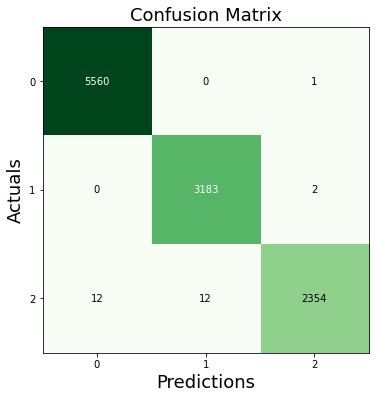

In [45]:
# Print the confusion matrix using Matplotlib
from sklearn.metrics import plot_confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_gb)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# 2.Adaboost Classifier Model

In [46]:
# Create adaboost classifer object
abc =AdaBoostClassifier(n_estimators=50, random_state=0)
print(abc)

# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)


# Model Accuracy of Adaboost Classifier Model
print("Accuracy:",accuracy_score(y_test, y_pred))

AdaBoostClassifier(random_state=0)
Accuracy: 0.7862279755483639


# Model Evaluation

In [47]:
#Print accuracy with confusion Matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy",accuracy_score(y_test, y_pred))  

Confusion Matrix:
[[5561    0    0]
 [   0 3185    0]
 [ 132 2246    0]]
Accuracy 0.7862279755483639


In [48]:
print("Classification Report")
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      5561
         1.0       0.59      1.00      0.74      3185
         2.0       0.00      0.00      0.00      2378

    accuracy                           0.79     11124
   macro avg       0.52      0.67      0.58     11124
weighted avg       0.66      0.79      0.71     11124



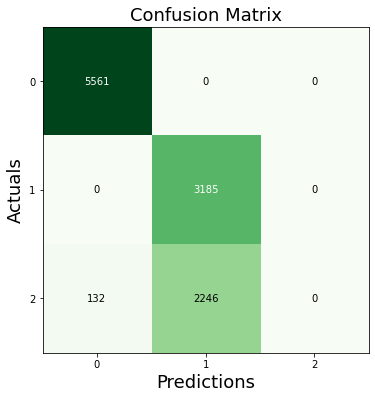

In [49]:
# Print the confusion matrix using Matplotlib
from sklearn.metrics import plot_confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# 3.Voting Classifier Model

In [50]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier

In [51]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()

In [52]:
# Set to hard, the voting classifier will make judgments based on the predictions that appear the most. 
#setting it to hard when using an odd number of classifiers because of its “majority carry the vote” approach.

vot_clf = VotingClassifier(estimators = [('lr', log_clf), ('rnd', rnd_clf), ('knn', knn_clf)], voting = 'hard')
vot_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rnd', RandomForestClassifier()),
                             ('knn', KNeighborsClassifier())])

In [53]:
y_pred = vot_clf.predict(X_test) 

# Accuracy of Voting Classifier Model
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.9663790003595829


# Model Evaluation

In [54]:
#Print accuracy with confusion Matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy",accuracy_score(y_test, y_pred))  

Confusion Matrix:
[[5426  126    9]
 [ 172 3006    7]
 [   4   56 2318]]
Accuracy 0.9663790003595829


In [55]:
print("Classification Report")
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      5561
         1.0       0.94      0.94      0.94      3185
         2.0       0.99      0.97      0.98      2378

    accuracy                           0.97     11124
   macro avg       0.97      0.96      0.97     11124
weighted avg       0.97      0.97      0.97     11124



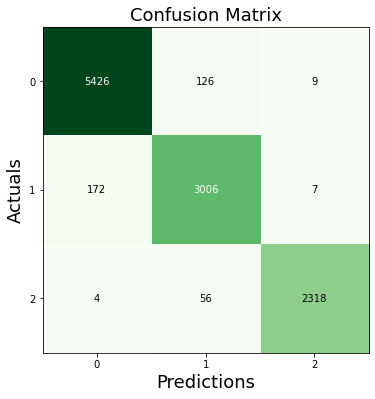

In [56]:
# Print the confusion matrix using Matplotlib
from sklearn.metrics import plot_confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# 4.Stacking Classifier Model

In [57]:
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
import numpy as np
import copy

# Define classifiers objects
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()

for clf in (clf1, clf2, clf3):
    clf.fit(X, y)
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr, fit_base_estimators=False)

labels = ['KNN', 'Random Forest', 'Naive Bayes', 'StackingClassifier']
print(sclf)

StackingClassifier(classifiers=[KNeighborsClassifier(n_neighbors=1),
                                RandomForestClassifier(random_state=1),
                                GaussianNB()],
                   fit_base_estimators=False,
                   meta_classifier=LogisticRegression())


In [58]:
sclf.fit(X_train, y_train)
model_stack = clf.fit(X_train, y_train)   # training of stacked model
pred_stack = model_stack.predict(X_test)       # predictions on test data using stacked model

print("Accuracy", accuracy_score(y_test, pred_stack))  # evaluating accuracy

Accuracy 0.608594030924128


# Model Evaluation

In [59]:
#Print accuracy with confusion Matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_stack))
print("Accuracy",accuracy_score(y_test, pred_stack))  

Confusion Matrix:
[[4888   82  591]
 [ 780 1873  532]
 [1103 1266    9]]
Accuracy 0.608594030924128


In [60]:
print("Classification Report")
print(classification_report(y_test, pred_stack))

Classification Report
              precision    recall  f1-score   support

         0.0       0.72      0.88      0.79      5561
         1.0       0.58      0.59      0.58      3185
         2.0       0.01      0.00      0.01      2378

    accuracy                           0.61     11124
   macro avg       0.44      0.49      0.46     11124
weighted avg       0.53      0.61      0.56     11124



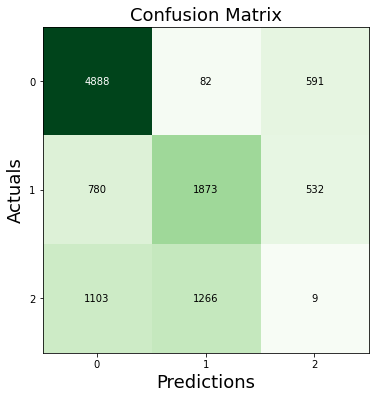

In [61]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=pred_stack)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# 5. K Neighbour Classifier Model

In [62]:
KNC= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 )  
#KNC = KNeighborsClassifier()   # initialising KNeighbors Classifier
NB = GaussianNB()              # initialising Naive Bayes
print(KNC)
model_kNeighborsClassifier = KNC.fit(X_train, y_train)   # fitting Training Set
pred_knc = model_kNeighborsClassifier.predict(X_test)   # Predicting on test dataset

KNeighborsClassifier()


In [63]:
#Print Accuracy for NB Classifier
print ("Accuracy", accuracy_score(y_test, pred_knc))  # evaluating accuracy score

Accuracy 0.9394102840704782


# Model Evaluation

In [64]:
#Print accuracy with confusion Matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, pred_knc))
print("Accuracy",accuracy_score(y_test, pred_knc))  

Confusion Matrix:
[[5240  300   21]
 [  87 2966  132]
 [  31  103 2244]]
Accuracy 0.9394102840704782


In [65]:
print("Classification Report")
print(classification_report(y_test, pred_knc))

Classification Report
              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96      5561
         1.0       0.88      0.93      0.91      3185
         2.0       0.94      0.94      0.94      2378

    accuracy                           0.94     11124
   macro avg       0.93      0.94      0.93     11124
weighted avg       0.94      0.94      0.94     11124



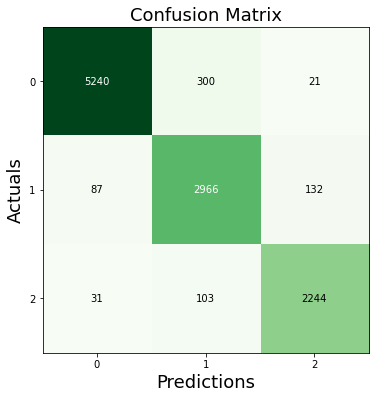

In [66]:
# Print the confusion matrix using Matplotlib
from sklearn.metrics import plot_confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=pred_knc)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# 6. Decision Tree Classifier Model

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Fit the classifier with default hyper-parameters
dt = DecisionTreeClassifier(random_state=100)
print(dt)
# Fitting the Model
dt_model=dt.fit(X_train,y_train)
y_pred=dt.predict(X_test)

DecisionTreeClassifier(random_state=100)


In [68]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score,recall_score,f1_score

print("Accuracy",accuracy_score(y_test,y_pred))

Accuracy 0.9999101042790364


# Model Evaluation

In [69]:
#Print accuracy with confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred)) 
print("Accuracy",accuracy_score(y_test, y_pred))  

Confusion Matrix:
[[5561    0    0]
 [   0 3184    1]
 [   0    0 2378]]
Accuracy 0.9999101042790364


In [70]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5561
         1.0       1.00      1.00      1.00      3185
         2.0       1.00      1.00      1.00      2378

    accuracy                           1.00     11124
   macro avg       1.00      1.00      1.00     11124
weighted avg       1.00      1.00      1.00     11124



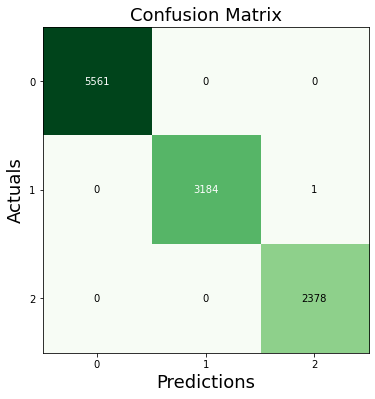

In [71]:
# Print the confusion matrix using Matplotlib
from sklearn.metrics import plot_confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [72]:
#X is feature column and y is target column
features = ['YearI', 'Industry_aggregation_NZSIOCI', 'Industry_code_NZSIOCI',
       'Industry_name_NZSIOCI', 'Variable_codeI', 'Variable_nameI',
        'ValueI']

X = enterprise_df[features]
y = enterprise_df['Variable_categoryI']

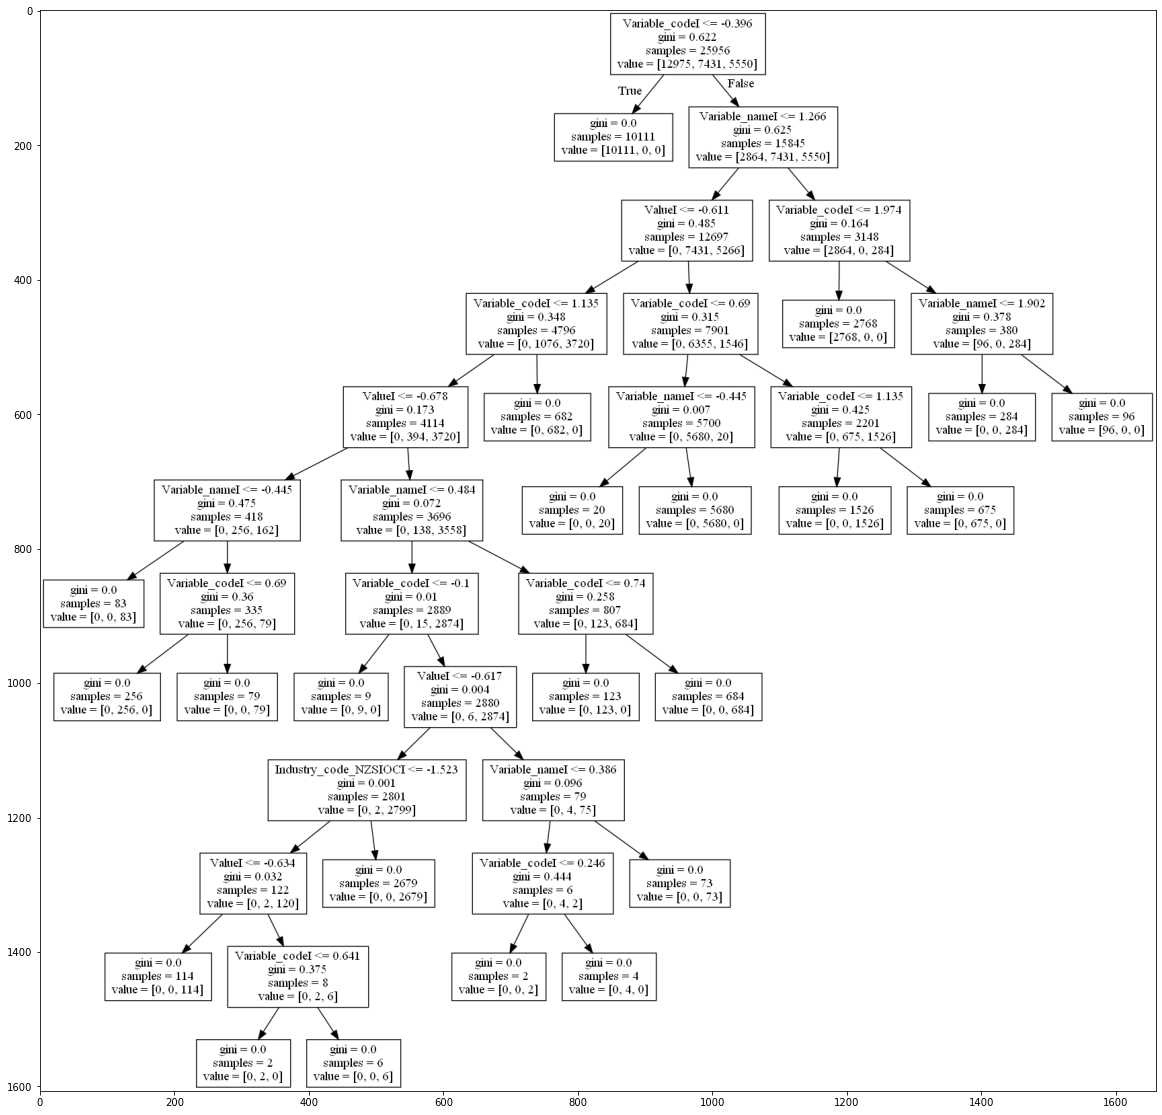

In [73]:
from sklearn import tree
import pydotplus
import matplotlib.pyplot as plt
import matplotlib.image as pltimg

data = tree.export_graphviz(dt, out_file=None, feature_names=features)
graph = pydotplus.graph_from_dot_data(data)
graph.write_png('mydecisiontree.png')
img = plt.figure(figsize=(20,20))
img=pltimg.imread('mydecisiontree.png')
imgplot = plt.imshow(img)
plt.show()

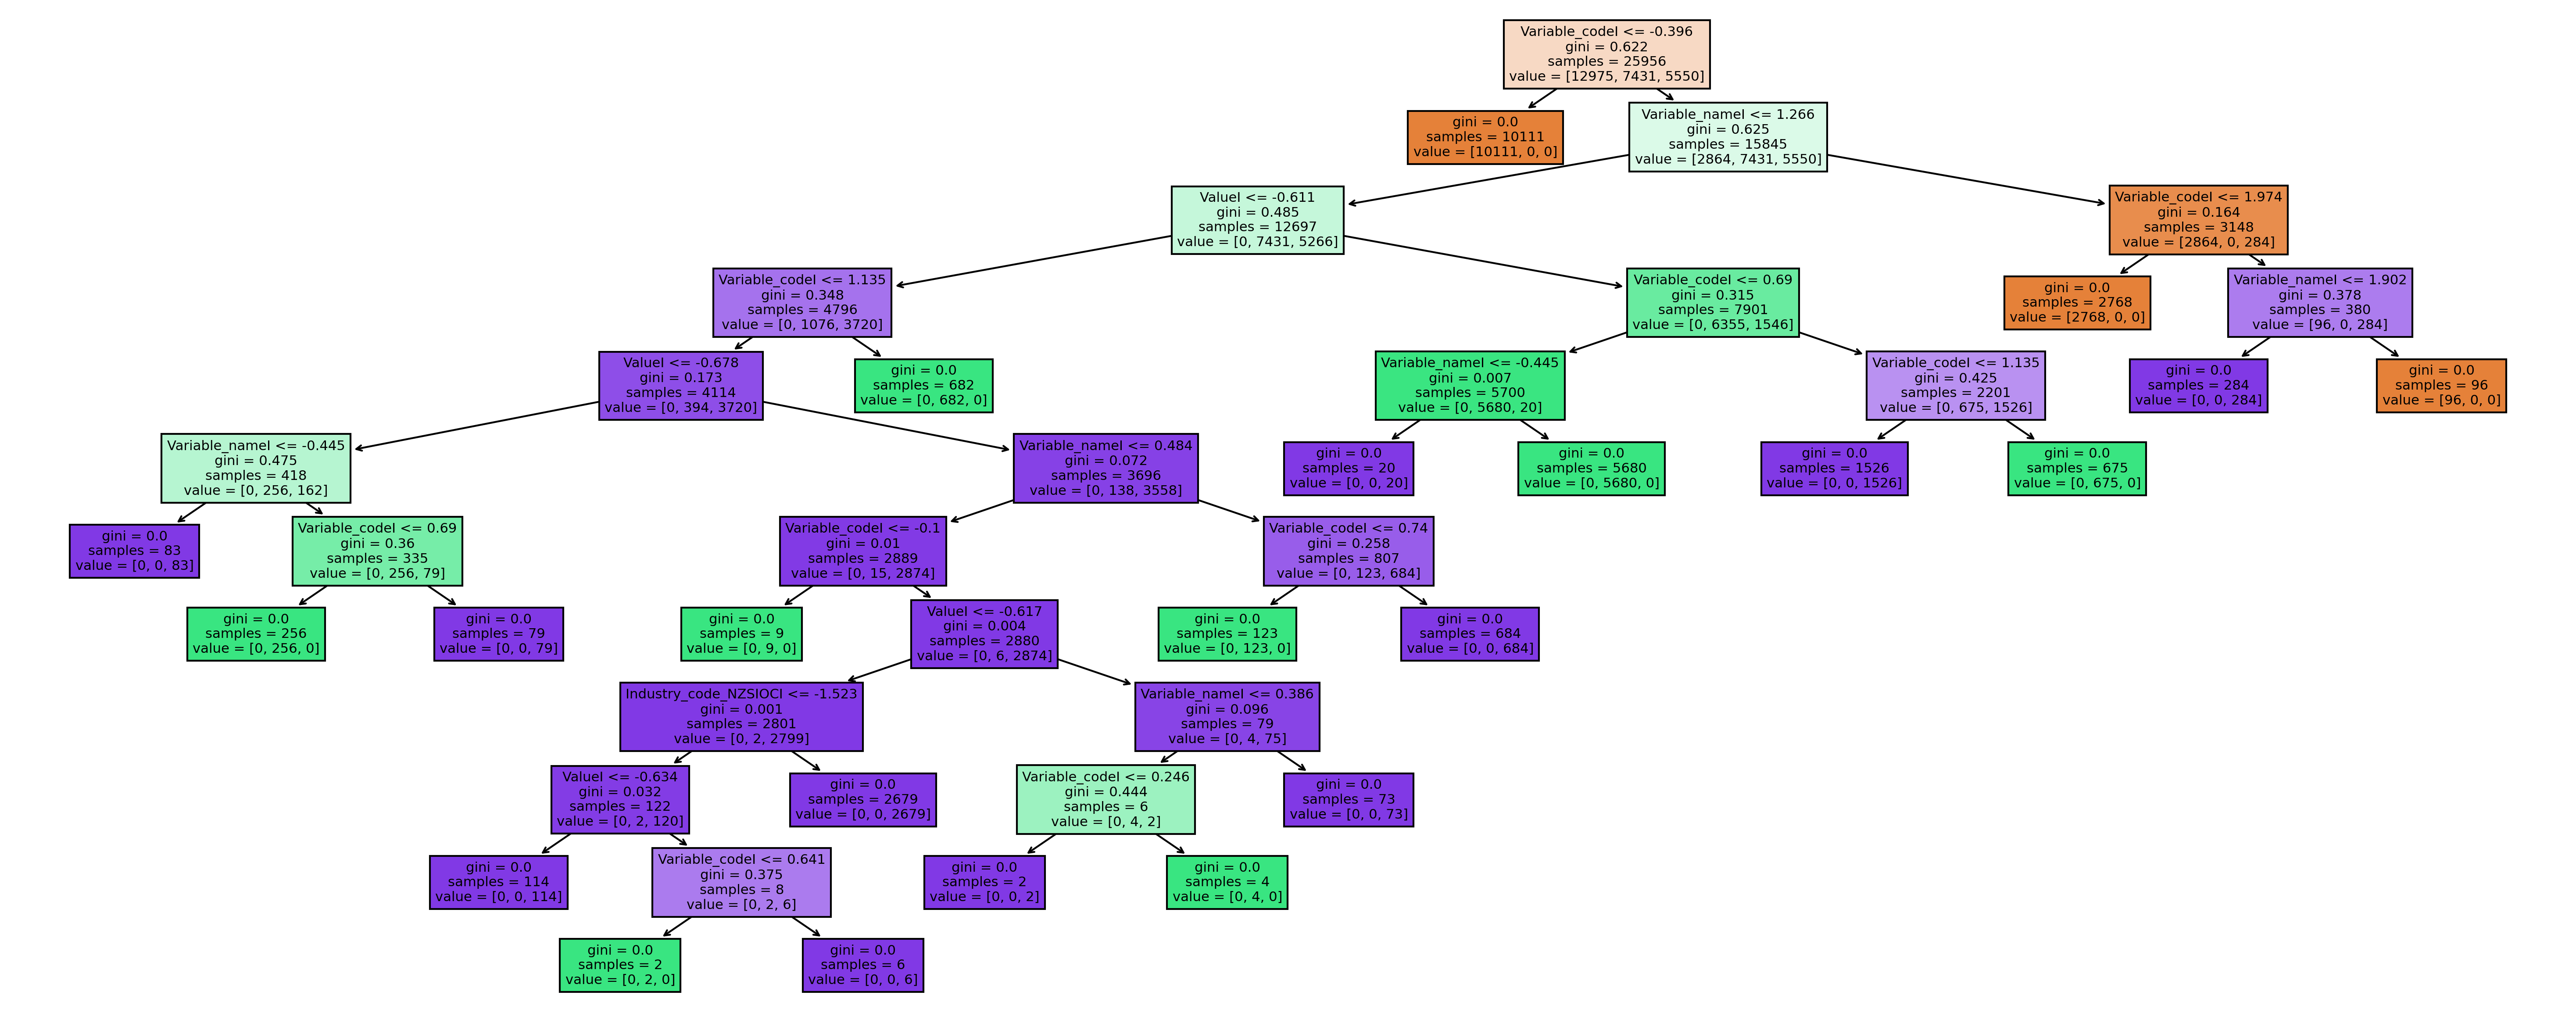

In [74]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (25,10), dpi=300)
tree.plot_tree(dt, feature_names=features, 
                   class_names=None,
                   filled=True);

fig.savefig("mydecisiontree.png") # save the file

# 7. Random Forest Tree Classifier Model

In [75]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn import tree

In [76]:
# Create RF classifier
rf_classification = RandomForestClassifier(n_estimators = 10, random_state = 10)
print(rf_classification)

RandomForestClassifier(n_estimators=10, random_state=10)


In [77]:
# use fit() to fit the model on the train set
rf_model = rf_classification.fit(X_train, y_train)

y_pred_rf=rf_model.predict(X_test)

print("Accuracy",accuracy_score(y_test,y_pred_rf)) # The accuracy achieved by our random forest classifier with 10 trees is 99.99%.

Accuracy 0.9999101042790364


# Model Evaluation

In [78]:
# View confusion matrix for test data and predictions
# Print accuracy with Confusion Matrix

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Accuracy",accuracy_score(y_test, y_pred_rf))  

Confusion Matrix:
[[5561    0    0]
 [   0 3185    0]
 [   1    0 2377]]
Accuracy 0.9999101042790364


In [79]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5561
         1.0       1.00      1.00      1.00      3185
         2.0       1.00      1.00      1.00      2378

    accuracy                           1.00     11124
   macro avg       1.00      1.00      1.00     11124
weighted avg       1.00      1.00      1.00     11124



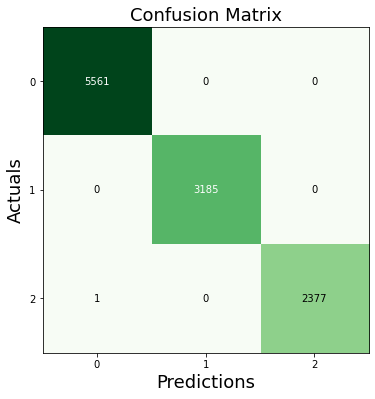

In [80]:
# Print the confusion matrix using Matplotlib
from sklearn.metrics import plot_confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_rf)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# 8 SVM Classifier

In [81]:
# training a linear SVM classifier
from sklearn.svm import SVC
svm_model = SVC(kernel = 'linear', C = 1).fit(X_train, y_train) # Fitting the Model

y_pred = svm_model.predict(X_test)

In [82]:
print("Accuracy",accuracy_score(y_test,y_pred))

Accuracy 0.6615426105717368


# Model Evaluation

In [83]:
#Print accuracy with confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred)) 
print("Accuracy",accuracy_score(y_test, y_pred)) 

Confusion Matrix:
[[4467  339  755]
 [1217 1378  590]
 [ 252  612 1514]]
Accuracy 0.6615426105717368


In [84]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5561
         1.0       1.00      1.00      1.00      3185
         2.0       1.00      1.00      1.00      2378

    accuracy                           1.00     11124
   macro avg       1.00      1.00      1.00     11124
weighted avg       1.00      1.00      1.00     11124



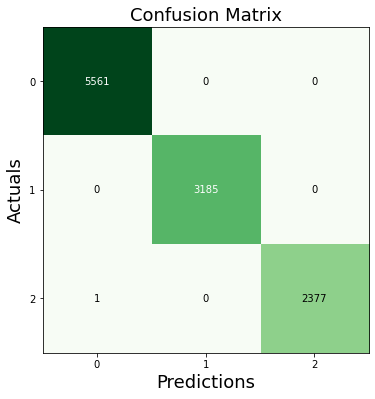

In [85]:
# Print the confusion matrix using Matplotlib
from sklearn.metrics import plot_confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_rf)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# 9. XGBoost Classifier Model with features Importance

In [86]:
# use feature importance for feature selection, with fix for xgboost 1.0.2 and fine accuracy for features.

from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel 

In [87]:
# define custom class to fix bug in xgboost 1.0.2
class MyXGBClassifier(XGBClassifier):
	@property
	def coef_(self):
		return None

In [88]:
# fit model on all training data
model = MyXGBClassifier()
model.fit(X_train, y_train)

# make predictions for test data and evaluate
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
	# select features using threshold
    
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
    
	# train model
	selection_model = XGBClassifier()
	selection_model.fit(select_X_train, y_train)
    
	# eval model
	select_X_test = selection.transform(X_test)
	predictions = selection_model.predict(select_X_test)
	accuracy = accuracy_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

[01:52:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 100.00%
[01:52:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=7, Accuracy: 100.00%
[01:52:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=7, Accuracy: 100.00%
[01:52:29] WARNING: D:\bld\xgboost-spl

In [ ]:
# In this method, the ExtraTreesClassifier method will help to give the importance of each independent feature with a dependent feature. Feature importance will give a score for each feature of data, the higher the score more important or relevant to the feature towards output variable.

[01:52:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


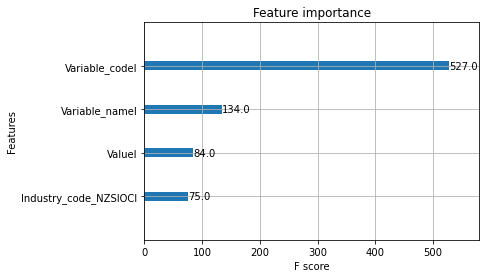

In [89]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

# fit model no training data
model = XGBClassifier()
model.fit(X, y)
# plot feature importance
plot_importance(model)
pyplot.show()

# Comparison of Classifiers in accordance with accuracy

In [90]:
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [91]:
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('ADB',AdaBoostClassifier(n_estimators=50, random_state=0)))
models.append(('VT',VotingClassifier(estimators = [('lr', log_clf), ('rnd', rnd_clf), ('knn', knn_clf)], voting = 'hard')))
models.append(('CART', DecisionTreeClassifier(random_state=1234)))
models.append(('KNC', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier(n_estimators = 10, random_state = 10)))

In [92]:
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) # print mean accuracy and standard deviation accuracy
	print(msg)

LR: 0.549326 (0.023248)
GB: 1.000000 (0.000000)
ADB: 0.786192 (0.003634)
VT: 0.926645 (0.005218)
CART: 0.999946 (0.000162)
KNC: 0.845173 (0.007322)
RF: 0.999919 (0.000173)
